# Setup and exploring/cleaning the data

The challenge provides two tables of data stored in csv files, the test_results data and the user (user_table) data, which are related by the user_id column. I'll start by reading both tables into pandas dataframes with correct column names.

In [92]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

test_results = pd.read_csv("../test_results.csv", index_col=0)
test_results.head(10)

,user_id,timestamp,source,device,operative_system,test,price,converted
0,604839,2015-05-08 03:38:34,ads_facebook,mobile,iOS,0,39.0,0
1,624057,2015-05-10 21:08:46,seo-google,mobile,android,0,39.0,0
2,317970,2015-04-04 15:01:23,ads-bing,mobile,android,0,39.0,0
3,685636,2015-05-07 07:26:01,direct_traffic,mobile,iOS,1,59.0,0
4,820854,2015-05-24 11:04:40,ads_facebook,web,mac,0,39.0,0
5,169971,2015-04-13 12:07:08,ads-google,mobile,iOS,0,39.0,0
6,600150,2015-03-04 14:45:44,seo_facebook,web,windows,0,39.0,0
7,798371,2015-03-15 08:19:29,ads-bing,mobile,android,1,59.0,1
8,447194,2015-03-28 12:28:10,ads_facebook,web,windows,1,59.0,0
9,431639,2015-04-24 12:42:18,ads_facebook,web,windows,1,59.0,0


In [2]:
user_table = pd.read_csv("../user_table.csv")
user_table.head(10)

,user_id,city,country,lat,long
0,510335,Peabody,USA,42.53,-70.97
1,89568,Reno,USA,39.54,-119.82
2,434134,Rialto,USA,34.11,-117.39
3,289769,Carson City,USA,39.15,-119.74
4,939586,Chicago,USA,41.84,-87.68
5,229234,New York,USA,40.67,-73.94
6,339138,Durham,USA,35.98,-78.91
7,270353,New York,USA,40.67,-73.94
8,166748,Burke,USA,38.78,-77.27
9,167700,New York,USA,40.67,-73.94


Now that the data has been read in and appears to have been formatted correctly, let's describe() both dataframes to check if the numerical values are all present (describe will ignore the text columns) and to see if we can glean anything from the simple stats provided by describe.

In [3]:
test_results.describe()

,user_id,test,price,converted
count,316800.000000,316800.000000,3.168000e+05,316800.000000
mean,499281.341840,0.360079,6.457590e+06,0.018333
std,288591.154044,0.480024,6.797307e+07,0.134154
min,3.000000,0.000000,3.900000e+01,0.000000
25%,249525.750000,0.000000,3.900000e+01,0.000000
50%,499021.500000,0.000000,3.900000e+01,0.000000
75%,749025.500000,1.000000,5.900000e+01,0.000000
max,1000000.000000,1.000000,9.998843e+08,1.000000


In [4]:
user_table.describe()

,user_id,lat,long
count,275616.000000,275616.000000,275616.000000
mean,499245.801521,37.111680,-93.981772
std,288533.458944,5.209627,18.086486
min,3.000000,19.700000,-157.800000
25%,249544.500000,33.660000,-112.200000
50%,498861.000000,37.740000,-88.930000
75%,748856.500000,40.700000,-78.910000
max,999999.000000,61.180000,30.310000


### Information gleaned from describe():

1. The mean of the price column is in the millions, even though that column should ony contain 39 or 59. It seems likely there is some corrupt/incorrect data in that column.
2. There are fewer user_id values in the user_table than the test_results. 

Both of these issues bear further investigation, which I will do below.

### Investigating the price column

In [5]:
test_results["price"].value_counts()

39.0           200747
59.0           112979
536537851.0         1
722005503.0         1
362003840.0         1
                ...  
874195411.0         1
873981330.0         1
436979943.0         1
873865897.0         1
537168484.0         1
Name: price, Length: 3076, dtype: int64

The good news is that 39 and 59 are the most frequently occurring values! Every value after that occurs once and is O(10^6). Really looks like some kind of corruption. Based on the output of value_counts(), there are 3074 rows affected by this issue, representing around 1% of the dataset. Since this is such a small fraction of a relatively large dataset, I think the safest approach is to drop those rows for now, but an investigation into how they were corrupted may be worthwhile.

In [6]:
test_results_clean = test_results[test_results["price"].isin([39.0, 59.0])]
test_results_clean.describe()

,user_id,test,price,converted
count,313726.000000,313726.000000,313726.000000,313726.000000
mean,499310.967401,0.359945,46.202400,0.018325
std,288608.449903,0.479985,9.600715,0.134124
min,3.000000,0.000000,39.000000,0.000000
25%,249495.250000,0.000000,39.000000,0.000000
50%,499200.000000,0.000000,39.000000,0.000000
75%,749063.000000,1.000000,59.000000,0.000000
max,1000000.000000,1.000000,59.000000,1.000000


Finally, while I'm working with the price column, I'll check that the "test" and "price" columns are consistent.

In [7]:
test_results_clean["test"][test_results["price"] == 39].value_counts()

0    200593
1       154
Name: test, dtype: int64

In [8]:
test_results_clean["test"][test_results["price"] == 59].value_counts()

1    112770
0       209
Name: test, dtype: int64

It looks like there is some more inconsistency here (how was this data collected?), fortunately it is once again a small fraction of the overall dataset (209 + 154 = 363, ~0.1% of the data), so we should be safe to drop it.

In [11]:
# There is almost certainly a more efficient way of doing this, but since it only has to be run once I leave it for now.
mask = [True if (test_results_clean["price"].iloc[i] == 39 and test_results_clean["test"].iloc[i] == 0) 
        or (test_results_clean["price"].iloc[i] == 59 and test_results_clean["test"].iloc[i] == 1) 
        else False for i in range(len(test_results_clean))]
test_results_clean = test_results_clean[mask]

### Investigating the mismatched length of the test_results and user_table data

I'll start by checkign for duplicates in the user_id column

In [12]:
test_results["user_id"][test_results["user_id"].duplicated()]

Series([], Name: user_id, dtype: int64)

There are no duplicates, so nexts lets check if every user_id in test_results is present in the user_table. We can make a decision later about whether to drop data from test_results table if we don't have the user information. This will depend on how we end up using the information in the user_table.

In [13]:
test_results[test_results["user_id"].isin(user_table["user_id"])].describe()

,user_id,test,price,converted
count,275616.000000,275616.000000,2.756160e+05,275616.000000
mean,499245.801521,0.359878,6.470932e+06,0.018210
std,288533.458944,0.479965,6.809917e+07,0.133711
min,3.000000,0.000000,3.900000e+01,0.000000
25%,249544.500000,0.000000,3.900000e+01,0.000000
50%,498861.000000,0.000000,3.900000e+01,0.000000
75%,748856.500000,1.000000,5.900000e+01,0.000000
max,999999.000000,1.000000,9.998843e+08,1.000000


Since the counts of the above table are the same as the user_table, I conclude that all user_ids in user_table are present in test_results. Also of note is that the mean and std of the converted column are very close to the mean and std for the entire table (0.01833 vs 0.01821, 0.1341 vs 0.1337).

## Should the company sell its software for the original price or the new price? Has the test been running for too long?

I'm now in a position to look into the 1st and 3rd questions. First I will calculate the baseline conversion rate for the control group, i.e. users that were shown the original price of the software.

In [17]:
control_group = test_results_clean[test_results_clean["test"] == 0]
control_conversion = len(control_group[control_group["converted"] == 1])/len(control_group)
print("Control group conversion rate: {:.2f}%".format(100*control_conversion))

Control group conversion rate: 1.99%


In [19]:
test_group = test_results_clean[test_results_clean["test"] == 1]
test_conversion = len(test_group[test_group["converted"] == 1])/len(test_group)
print("Test group conversion rate: {:.2f}%".format(100*test_conversion))

Test group conversion rate: 1.56%


The first thing to note is some good news: Based on aggregate data, even though the conversion rate went down for the increased price, **overall revenue should still go up** (if 2 out of 100 customers by the software at 39, revenue = 78, if 1.5 out of 100 customers buy the software at 59, revenue = 88.5). **Therefore, the company should sell its software at the higher price!**

Now we can plug these numbers into an [A/B test calculator](https://www.optimizely.com/sample-size-calculator/?conversion=2&effect=25&significance=95) to obtain the sample size needed to detect a 25% change in conversion rate for a baseline conversion rate of 2%. **The answer for 95% confidence level is a sample size of 13000, so indeed the test has been running for far too long.**

Another way to reframe the problem is, whatever relative change in conversion rate are we sensitive to with a sample size of ~300,000 and a baseline conversion rate of 2%? The answer for 95% confidence level is around a 5% relative change. Ideally before running the test a target for relative change in conversion rate would have been established, so that the test could be stopped when the appropriate amount of data was collected.

## Actionable insights / customer segmentation

In order to glean some actionable insights from this data, I will segment customers based on the available information and determine if there is some segment that converts at a higher rate than others.

### Segmenting by device

The device might have some relationship with the conversion rate if the software is for example a mobile app, we might expect a lower conversion rate from non-mobile visits. In any case, I'll check:

In [71]:
test_results_clean["device"].unique()

array(['mobile', 'web', nan], dtype=object)

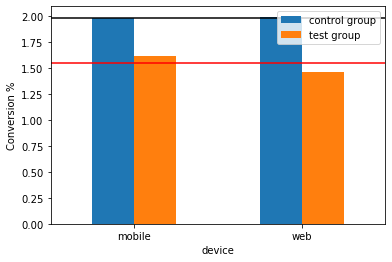

In [116]:
control_group_dev = test_results_clean[test_results_clean["test"] == 0].groupby("device")
test_group_dev = test_results_clean[test_results_clean["test"] == 1].groupby("device")

dev_list = list()
control_crs = list()
test_crs = list()
for device in test_results_clean["device"].unique():
    if type(device) != str:
        continue
    dev_list.append(device)
    control_crs.append(100*control_group_dev["converted"].value_counts()[device, 1]/control_group_dev["converted"].agg("count")[device])
    test_crs.append(100*test_group_dev["converted"].value_counts()[device, 1]/test_group_dev["converted"].agg("count")[device])

device_df = pd.DataFrame({"control group": control_crs, "test group": test_crs}, index=dev_list)
ax = device_df.plot.bar(rot=0)
plt.xlabel("device")
plt.ylabel("Conversion %")
plt.axhline(control_conversion*100, color='k')
plt.axhline(test_conversion*100, color='r')

Although it looks like there might be some dependence on the device in the test group, the fact that it isn't also present in the control group makes me suspect it is not statistically significant. This might bear further investigation if there is sufficient time, for example I might use bootstrapping to obtain the standard error on the mean of the conversion rate to determine if the mobile/web conversion rates for the test group are actually consistent with each other.

### Segmenting by operating system

The operating system could possibly have an impact on the conversion rate. The software might be more popular among users of a particular OS, which might inform where advertising dollars are spent.

In [43]:
test_results_clean["operative_system"].unique()

array(['iOS', 'android', 'mac', 'windows', nan, 'i0S', 'wnddows',
       'anroid', 'apple'], dtype=object)

I've discovered some data cleaning issues that weren't relevant previously! We have what looks like some typos that should be easy to clean up:

- i0S = iOS
- wnddows = windows
- anroid = android

Let's also make the assumption that "mac" and "apple" should be considered equivalent.

Finally we have some "nan" values that we can drop.

In [61]:
# CLEANING
test_results_clean.loc[:,"operative_system"] = test_results_clean.loc[:,"operative_system"].replace("i0S", "iOS")
test_results_clean.loc[:,"operative_system"] = test_results_clean.loc[:,"operative_system"].replace("wnddows", "windows")
test_results_clean.loc[:,"operative_system"] = test_results_clean.loc[:,"operative_system"].replace("anroid", "android")
test_results_clean.loc[:,"operative_system"] = test_results_clean.loc[:,"operative_system"].replace("apple", "mac")
test_results_clean.loc[:,"operative_system"] = test_results_clean.loc[:,"operative_system"].replace(np.nan, "None")
test_results_clean["operative_system"].unique()

array(['iOS', 'android', 'mac', 'windows', 'None'], dtype=object)

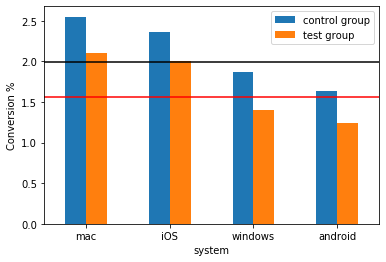

In [115]:
control_group_os = test_results_clean[test_results_clean["test"] == 0].groupby("operative_system")
test_group_os = test_results_clean[test_results_clean["test"] == 1].groupby("operative_system")

sys_list = list()
control_crs = list()
test_crs = list()
for system in test_results_clean["operative_system"].unique():
    if system == "None":
        continue
    sys_list.append(system)
    control_crs.append(100*control_group_os["converted"].value_counts()[system, 1]/control_group_os["converted"].agg("count")[system])
    test_crs.append(100*test_group_os["converted"].value_counts()[system, 1]/test_group_os["converted"].agg("count")[system])

system_df = pd.DataFrame({"control group": control_crs, "test group": test_crs}, index=sys_list)
system_df = system_df.sort_values(by="control group", ascending=False)
ax = system_df.plot.bar(rot=0)
plt.xlabel("system")
plt.ylabel("Conversion %")
plt.axhline(control_conversion*100, color='k')
plt.axhline(test_conversion*100, color='r')

There are strong indications that the conversion rate is higher for iOS and mac users, indicating that the software product is more popular among users of those devices. Further investigation into the reason for this might be very valuable. It could be related to where and how advertising dollars are being spent, or it could be as simple as the iOS/mac version having a more intuitive interface. In any case, undertanding the reason for this gap in popularity might lead to better conversion rates for android and windows users.

### Segmenting by source

In [73]:
test_results_clean["source"].unique()

array(['ads_facebook', 'seo-google', 'ads-bing', 'direct_traffic',
       'ads-google', 'seo_facebook', 'friend_referral', 'ads_other',
       'ads-yahoo', 'seo-yahoo', 'seo-bing', 'seo-other', nan],
      dtype=object)

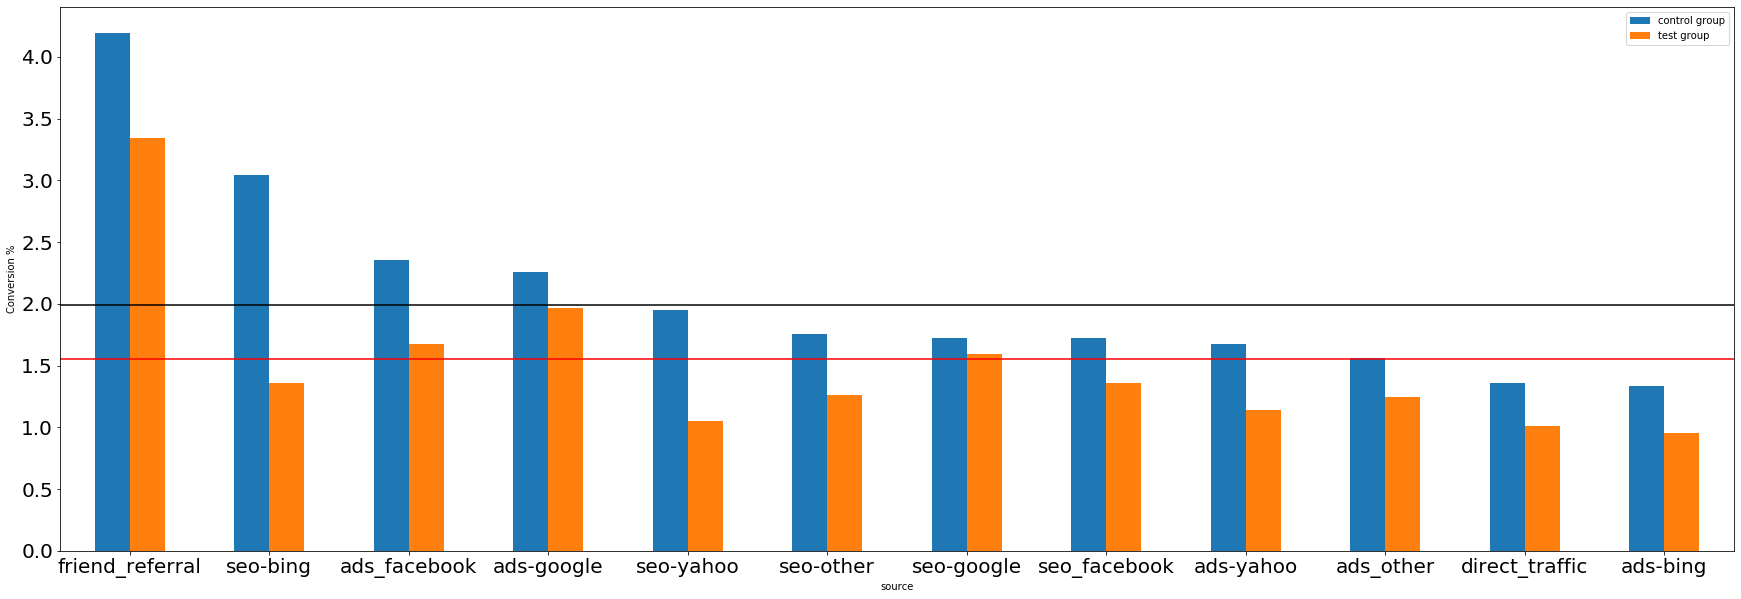

In [117]:
control_group_os = test_results_clean[test_results_clean["test"] == 0].groupby("source")
test_group_os = test_results_clean[test_results_clean["test"] == 1].groupby("source")

source_list = list()
control_crs = list()
test_crs = list()
for source in test_results_clean["source"].unique():
    if type(source) != str:
        continue
    source_list.append(source)
    control_crs.append(100*control_group_os["converted"].value_counts()[source, 1]/control_group_os["converted"].agg("count")[source])
    test_crs.append(100*test_group_os["converted"].value_counts()[source, 1]/test_group_os["converted"].agg("count")[source])

source_df = pd.DataFrame({"control group": control_crs, "test group": test_crs}, index=source_list)
source_df = source_df.sort_values(by="control group", ascending=False)
ax = source_df.plot.bar(rot=0, figsize=(30,10), fontsize=20)
plt.xlabel("source")
plt.ylabel("Conversion %")
plt.axhline(control_conversion*100, color='k')
plt.axhline(test_conversion*100, color='r')

Friend referrals are the source with by far the highest conversion rate. Encouraging referrals is therefore something that could be targetted to increase revenue and conversion rates, for example by offering incentives to existing users in exchange for referrals that lead to a successful conversion. 

In the control group, Bing SEO is also leading to more successful conversions than the aggregate, as are facebook ads and google ads. Bing SEO is not outperforming the aggregrate in the test group, which is slightly suspicious, however facebook adds and google adds are also leading to more successful conversions in the test group.

# Conclusions and next steps

To start I will sum up my answers to the 3 questions provided in the challenge:

1. **Should the company sell its software for 39 or 59?**

 * The company should sell its software for 59 dollars. This will lead to a drop in conversion rate but an overall increase in revenue


2. **The VP of Product is interested in having a holistic view into user behavior, especially focusing on actionable insights that might increase conversion rate. What are your main findings looking at the data?**

 * The conversion rate is higher for iOS and mac users than android or windows users. Before making decisions based on this information, I would try to understand the root cause of this difference. Is it related to the software itself? Is it related to how advertising is being targeted? The next steps to take to increase android/windows conversions should become clear once the cause is understood.
 * The conversion rate is higher for friend referrals, Bing SEO, facebook ads, and google ads. Based on this data, incentivizing successful referrals should increase revenue and hopefully conversion rates as well. For the rest, I think an assessment of how advertising dollars are being spent based on this data should also help increase conversions. The fact that direct traffic has a relatively low conversion rate may also be a concern. How recently was the company's website overhauled?
 
3. **The VP of Product feels that the test has been running for too long and she should have been able to get statistically significant results in a shorter time. Do you agree with her intuition? After how many days would you have stopped the test? Please, explain why.**

 * I agree that the test was running too long, as the relative change in conversion rate was 25% and this could have been detected with a sample size of 13,000. I didn't find the time to calculate how many days it took to reach the appropriate sample size, but this information is in the dataset and could be calculated relatively easily.
 
## Next steps

I think the most important next step would involve calculating the statistical strength of the conversion rates I calculated by segmenting the customer base. Bootstrapping the data and calculating standard errors would be my first approach, as a conversion rate for a segment of 2.1% +/- 0.2% is still consistent with the baseline of 2% and therefore I wouldn't make changes to company strategy based on that.

Beyond that, the data itself contains several avenues of exploration that I didn't manage to check:

1. I never used the geo data in the user_table, and there may be useful insights to draw from there. Are there more conversions from certain parts of the country? Rural vs urban? Etc.
2. The time stamp data in results_table might also provide useful information. Are there more conversions at a particular time of day, day of the week, etc?